# Homework Assignment Week 3 - Monte Carlo

This weeks homework is to apply a Monte Carlo technique in a unique OpenAI Gym environment (not blackjack). The different Monte Carlo techniques are detailed [here](https://oneraynyday.github.io/ml/2018/05/24/Reinforcement-Learning-Monte-Carlo/#example-cliff-walking).

Write a Medium blog post about your experience implementing the algorithm and what you learned. And (optionally) share your post on Twitter with the #move37 hashtag!  Siraj Raval.

### Monte Carlo GLIE: 2
Applied to Taxi-v2 environment

In [6]:
# import necessary libraries
import gym
from gym import wrappers
import numpy as np
import pandas as pd
import time


# Helper Functions
def update_report(report):
    '''
    Calculates training metrics and stores them in a pandas dataframe
    '''
    r = report
    r['last_avg_episode_score'] - r['avg_episode_score']
    r['avg_episode_score'] = sum(r['episode_reward_list']) / r['episode_window']
    
    # calculate delta
    delta = r['avg_episode_score'] - r['last_avg_episode_score']
    
    print(
        f"K episodes: {r['k_episodes']:>8.3f} "
        f"Average Episode Score: {r['avg_episode_score']:>10.3f} "
        f"Delta: {delta:>10.3f} "
        f"Epsilon: {r['epsilon']:>10.3f} "
    )
    
    # add to dataframe
    r['df'].loc[r['df_index']] = [
        r['k_episodes'],
        r['avg_episode_score'],
        delta,
        r['epsilon']
    ]
    
    r['df_index'] += 1
    
    # re-initialize rewards_list - allows us to only capture last
    # episode_window runs
    r['episode_reward_list'] = []
    

    
def get_epsilon(i, target_epsilon, num_episodes):
    '''
    Creates a function that changes the value of epsilon over time
    '''
    # allow us to test last 5% to see how much training it has done
    if i > num_episodes * 0.94:
        return 0.0
    else:
        return 0.3 * (1 - (i / num_episodes)) + target_epsilon



# Main
def main(num_episodes=10000, target_epsilon=0.2, episode_window=1000):
    start_time = time.time()
    
    # create our environment
    env = gym.make("Taxi-v2")
    #env = wrappers.Monitor(env, "./results", force=True)

    # initialize the action value function Q(s, a),
    # and a counter function N(s, a)
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    n_s_a = np.zeros([env.observation_space.n, env.action_space.n])

    # initialize report
    labels = ['k episodes', 'Average Total Score', 'Delta', 'Epsilon']
    report = {
        'episode_reward_list': [],
        'avg_episode_score': 0,              # average episode score per episode interval
        'last_avg_episode_score': 0,
        'df': pd.DataFrame(columns=labels),
        'df_index': 0,
        'episode_window': episode_window,
    }
    
    # set df labels type
    report['df'][labels] = report['df'][labels].astype(float)
    
    
    for i in range(num_episodes + 1):
        
        state = env.reset()
        done = False
        results_list = []
        episode_reward = 0
        
        while not done:
            if np.random.rand() < target_epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])
            new_state, step_reward, done, _ = env.step(action)
            results_list.append((state, action))
            episode_reward += step_reward
            state = new_state
            #r_all += reward
        
        report['episode_reward_list'].append(episode_reward)
        
        for (state, action) in results_list:
            n_s_a[state, action] += 1.0
            alpha = 1.0 / n_s_a[state, action]
            Q[state, action] += alpha * (episode_reward - Q[state, action])
        
        if i % report['episode_window'] == 0 and i is not 0:
            report['k_episodes'] = i / 1000.0
            report['epsilon'] = get_epsilon(i,
                                            target_epsilon, 
                                            num_episodes)
            
            # update report
            update_report(report)
    
    # close environment
    env.close()
    
    # calculate run time
    end_time = time.time()
    run_time = end_time - start_time
    print(f"Time taken: {run_time:10.2f} seconds")
    return report['df'], run_time

### Episodes: 10000 Target_epsilon=0.2

In [7]:
num_episodes = 10000
target_epsilon = 0.2 # Epsilon controls the probability of taking a random action vs following policy

df, run_time = main(num_episodes=num_episodes, target_epsilon=target_epsilon)
print(f'Data Frame Size: {df.shape}')

K episodes:    1.000 Average Episode Score:   -442.717 Delta:   -442.717 Epsilon:      0.470 
K episodes:    2.000 Average Episode Score:   -324.483 Delta:   -324.483 Epsilon:      0.440 
K episodes:    3.000 Average Episode Score:   -315.171 Delta:   -315.171 Epsilon:      0.410 
K episodes:    4.000 Average Episode Score:   -318.417 Delta:   -318.417 Epsilon:      0.380 
K episodes:    5.000 Average Episode Score:   -313.413 Delta:   -313.413 Epsilon:      0.350 
K episodes:    6.000 Average Episode Score:   -303.440 Delta:   -303.440 Epsilon:      0.320 
K episodes:    7.000 Average Episode Score:   -297.103 Delta:   -297.103 Epsilon:      0.290 
K episodes:    8.000 Average Episode Score:   -304.983 Delta:   -304.983 Epsilon:      0.260 
K episodes:    9.000 Average Episode Score:   -295.856 Delta:   -295.856 Epsilon:      0.230 
K episodes:   10.000 Average Episode Score:   -280.838 Delta:   -280.838 Epsilon:      0.000 
Time taken:      43.18 seconds
Data Frame Size: (10, 4)


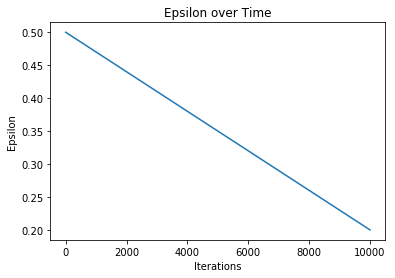

In [3]:
# Plot Epsilon
num_episodes = 10000
target_epsilon = 0.2

def calculate_epsilon(i, num_episodes, target_epsilon):
    return 0.3 * (1 - (i / num_episodes)) + target_epsilon

iterations = [i for i in range(num_episodes + 1)]
epsilons = [calculate_epsilon(i, num_episodes, target_epsilon)
           for i in range(num_episodes + 1)]

plt.plot(iterations, epsilons)
plt.title('Epsilon over Time')
plt.ylabel('Epsilon')
plt.xlabel('Iterations')
plt.show()

---

# Report

### Introduction
For assignment 3 of Move 37, we had to apply a Monte Carlo technique to a unique [OpenAI Gym environment][openai-gym-envs] other than Blackjack.

For this assignment, I collaborated with [Andrew Key][ak github]. Here is a link to [Andrew Key's Colab][colab-link], which contains some awesome plots, including a heatmap of the untrained and trained Q-Functions.

We chose to apply the Monte Carlo GLIE learning policy to the [Taxi-v2 Environment][openai-gym-taxi-v2] for this assignment. We started off with this [code][original code], which applies Monte Carlo GLIE to the [FrozenLake-v0 environment][openai-gym-frozenlake-v0].


### Taxi-v2 Environment Details

In the **Taxi-v2** environment, there are 4 destination locations in the grid world. At the start of an episode, the taxi and passenger start off at random locations. The taxi drives to the passenger's location, picks up the passenger, then drives to the passenger's destination and drops off the passenger. Once the passenger is dropped off, the episode ends.

During our testing, we discovered that an episode also ended at the 200 timestep even if it failed to drop off the passenger correctly. This is shown in the log output sample below, where we have extracted all the instances where done is True, indicating an episode's completion:

``` 
$ cat taxi_v2.log | grep -n 'True'  
202:New State:334|Reward:-1|done?:True|_:{'prob': 1.0}  
402:New State:468|Reward:-10|done?:True|_:{'prob': 1.0}  
602:New State:446|Reward:-1|done?:True|_:{'prob': 1.0}  
802:New State:476|Reward:-1|done?:True|_:{'prob': 1.0}  
1002:New State:451|Reward:-10|done?:True|_:{'prob': 1.0}  
1202:New State:452|Reward:-1|done?:True|_:{'prob': 1.0}  
1402:New State:421|Reward:-1|done?:True|_:{'prob': 1.0}  
```


### Monte Carlo GLIE
[Monte Carlo methods][wiki-monte-carlo] are a family of computation algorithms that rely on repeated random sampling to obtain numerical results. The essential idea is to use randomness to solve problems that might be deterministic in principle. In the context of Reinforcement Learning, they are used for Model-Free Learning, which learns from experience. This approach is used when we don't have perfect knowledge about the environment - no rewards function or transition probabilities are known ahead of time. So our agent has to discover these values through trial and error, e.g. experience. 

There are several types of Monte Carlo methods at our disposal for Reinforcement Learning. GLIE, which stands for Greedy in the Limit with Infinite Exploration is one such learning policy. A GLIE learning policy satisfies the following two properties:

- Exploration should continue indefinitely
- The probability of exploration ($\epsilon$) should decrease over time


### Reward Evaluation
Initially we were dividing the $total\_rewards$ at time $t$ by the number of episodes at time $t$. This comprehensive average was not helpful when determining whether progress was being made. So, instead we focused on a single episode window and found that the average reward for that episode window was a more informative metric.

To evaluate that our agent was learning, we used the following reward equation:

$$ reward = \frac{total\_rewards}{episode\_window} $$

where:
- $episode\_window$ is the number of episodes between report entries
- $total\_rewards$ is below:

$$ total\_rewards = \sum_{i=s}^{t} episode\_reward_i $$

where:
- $t$ is the current episode
- $s$ is $ t - episode\_window $
- $episode\_reward$ is the sum of all $step\_reward$s within an episode

### Epsilon
For the first 95\% that we trained the Q-Function, $ \epsilon $ was calculated with the following equation:

$$ \epsilon = 0.3 * (1 - \frac{i}{num\_episodes}) + target\_\epsilon $$

where:
- $target\_\epsilon$ is the lower bound $\epsilon$ value. It was set to 0.2.
- $i$ is the current iteration
- $num\_episodes$ is the number of episodes

Note that $\epsilon$ is decaying over time, but that exploration will always happen, thanks to $target\_\epsilon$ being 0.2. This satisfies the necessary conditions for the GLIE learning policy.

For the last 5\%, $\epsilon$ was set to 0. This allowed us to evaluate how well the Q-Function had trained so far. The plot below shows the value of Epsilon over time.

[original code]: https://gist.github.com/Sathishruw/d609e358b61268cdf891cc93e15e5f63
[ak github]: https://github.com/redpanda-ai
[openai-gym-envs]: https://gym.openai.com/envs/
[openai-gym-taxi-v2]: https://gym.openai.com/envs/Taxi-v2/
[openai-gym-frozenlake-v0]: https://gym.openai.com/envs/FrozenLake-v0/
[colab-link]: https://colab.research.google.com/drive/1yw9BhzEtH6ZN9siUJqiNlwzX0_c35LL_
[wiki-monte-carlo]: https://en.wikipedia.org/wiki/Monte_Carlo_method

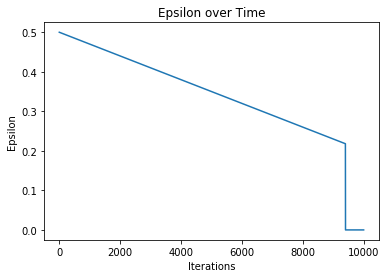

In [1]:
# Import for plots
import matplotlib.pyplot as plt
%matplotlib inline

# Plot Epsilon
num_episodes = 10000
target_epsilon = 0.2

def calculate_epsilon(i, num_episodes, target_epsilon):
    if i > num_episodes * 0.94:
        return 0.0
    else:
        return 0.3 * (1 - (i / num_episodes)) + target_epsilon

iterations = [i for i in range(num_episodes + 1)]
epsilons = [calculate_epsilon(i, num_episodes, target_epsilon)
           for i in range(num_episodes + 1)]

plt.plot(iterations, epsilons)
plt.title('Epsilon over Time')
plt.ylabel('Epsilon')
plt.xlabel('Iterations')
plt.show()

## Resources
- [David Silver's Control Slides](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/control.pdf)
- [Nahum Shimkin's course: Chapter 7 Efficient Exploration](http://webee.technion.ac.il/shimkin/LCS11/ch7_exploration.pdf)
- [Sathishruw's Gist - Monte Carlo GLIE Python Implementation](https://gist.github.com/Sathishruw/d609e358b61268cdf891cc93e15e5f63)
- [Ray's Blog - Reinforcement Learning - Monte Carlo](https://oneraynyday.github.io/ml/2018/05/24/Reinforcement-Learning-Monte-Carlo/)
- [Krisztian Kovacs Blog: Exploration vs Exploitation](https://krisztiankovacs.com/rl-notes-3-exporation-vs-exploitation/)

---

# Project Extension Ideas

- Test with different parameters
- Have an agent interact in an environment with a trained Q-Function.